In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as pyp
import numpy as np
import matplotlib.ticker as ticker

import pkg_vtt_extract as vtt

%load_ext autoreload
%autoreload 2

In [27]:
vtt.combine_two_part_ep('C1', 'Denouement _ Critical Role RPG Show Episode 35, pt. 1.en.vtt', 'Denouement _ Critical Role RPG Show Episode 35, pt. 2.en.vtt', 35)

vtt.combine_two_part_ep('C1', 'Gunpowder Plot, pt. 1  _ Critical Role RPG Show Episode 31.en.vtt', 'Gunpowder Plot, pt. 2  _ Critical Role RPG Show Episode 31.en.vtt', 31)

vtt.combine_two_part_ep('C1', 'Reunions _ Critical Role RPG Show Episode 33, pt. 1.en.vtt', 'Reunions _ Critical Role RPG Show Episode 33, pt. 2.en.vtt', 33)

In [45]:
vtt.rename_vtt('C1')
vtt.rename_vtt('C2')

In [15]:
C1_processed_vtt_df = vtt.episode_extract('C1', 1, 115)
C1_processed_vtt_df.to_csv('data_output/C1_processed_vtt_df.csv')

Completed: ep  10
Completed: ep  20
Completed: ep  30
Completed: ep  40
Completed: ep  50
Completed: ep  60
Completed: ep  70
Completed: ep  80
Completed: ep  90
Completed: ep  100
Completed: ep  110
Completed: all


In [4]:
C1_processed_vtt = pd.read_csv('data_output/C1_processed_vtt_df.csv')
C1_org_name = vtt.org_time_person(C1_processed_vtt, 'C1')

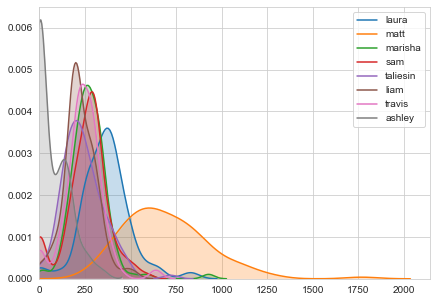

In [34]:
vtt.densityplot_time_per_ep(C1_org_name)

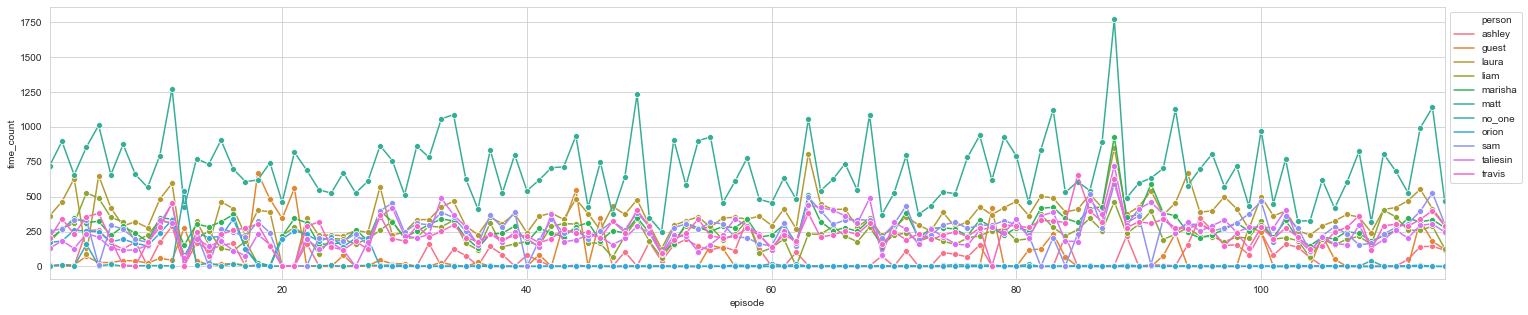

In [30]:
vtt.lineplot_per_ep(C1_org_name, 'matt', 'C1')

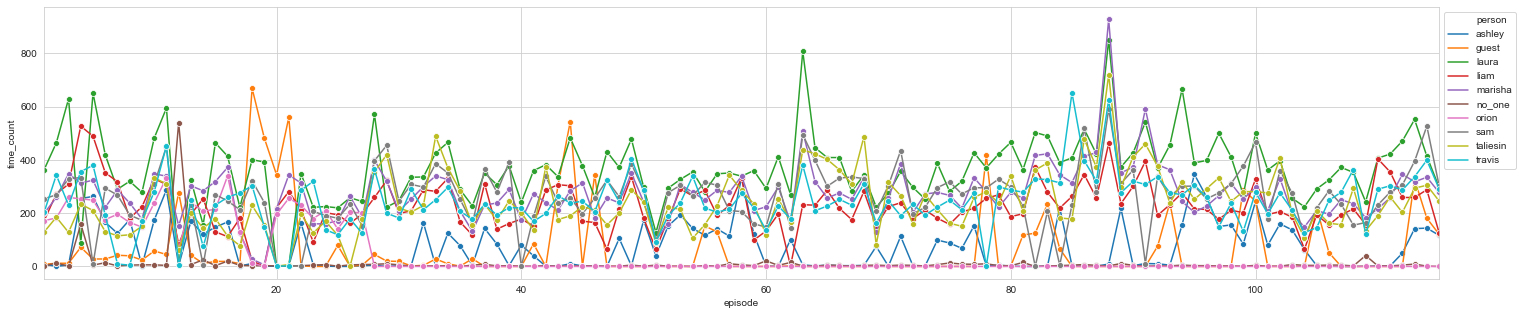

In [31]:
vtt.lineplot_per_ep(C1_org_name, 'nomatt', 'C1')

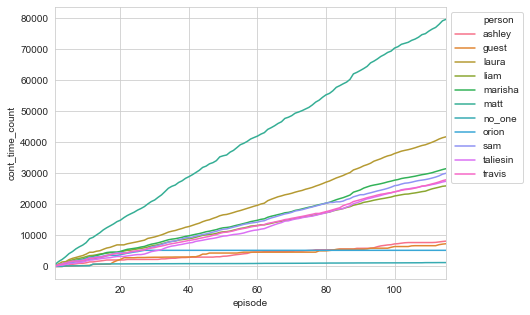

In [32]:
vtt.lineplot_cont_count(C1_org_name, 'matt', 'C1')

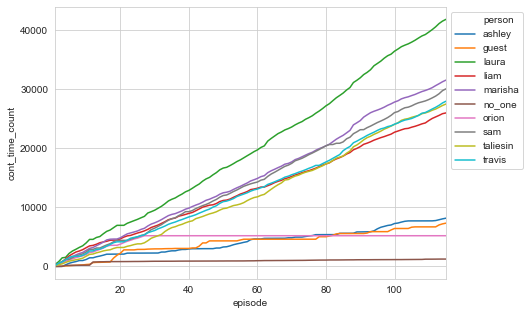

In [33]:
vtt.lineplot_cont_count(C1_org_name, 'nomatt', 'C1')

In [52]:
C2_processed_vtt_df = vtt.episode_extract('C2', 1, 90)
C2_processed_vtt_df.to_csv('data_output/C2_processed_vtt_df.csv')

Completed: ep  10
Completed: ep  20
Completed: ep  30
Completed: ep  40
Completed: ep  50
Completed: ep  60
Completed: ep  70
Completed: ep  80
Completed: ep  90
Completed: all


In [21]:
C2_processed_vtt = pd.read_csv('data_output/C2_processed_vtt_df.csv')
C2_org_name = vtt.org_time_person(C2_processed_vtt, 'C2')

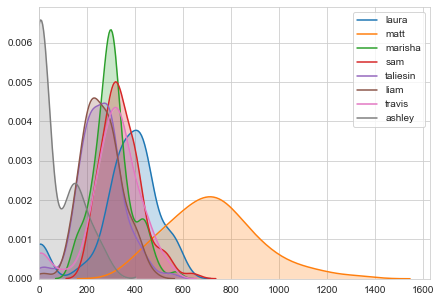

In [35]:
vtt.densityplot_time_per_ep(C2_org_name)

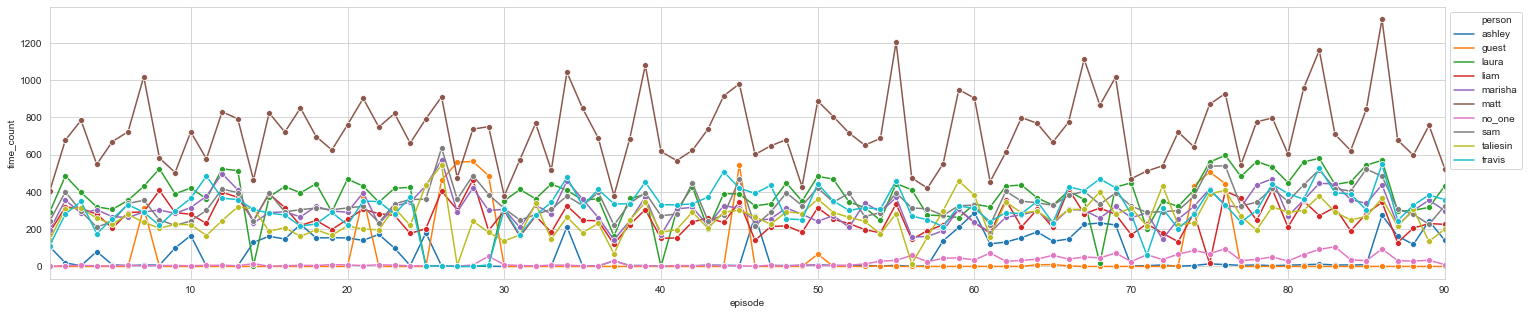

In [36]:
vtt.lineplot_per_ep(C2_org_name, 'matt', 'C2')

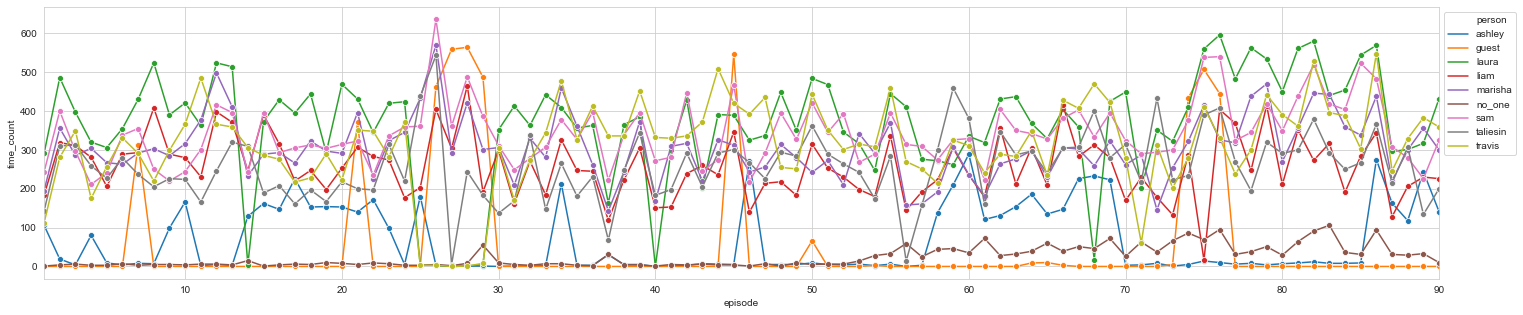

In [37]:
vtt.lineplot_per_ep(C2_org_name, 'nomatt', 'C2')

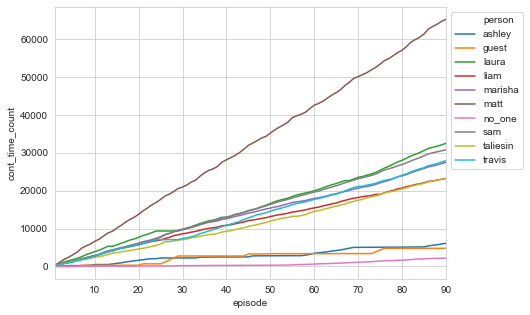

In [38]:
vtt.lineplot_cont_count(C2_org_name, 'matt', 'C2')

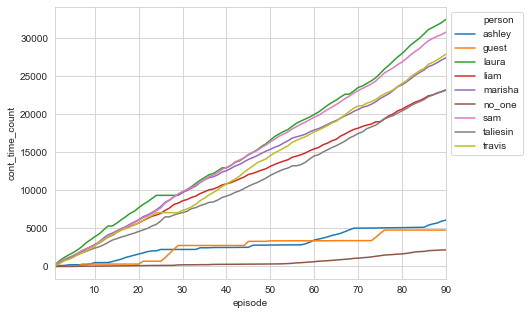

In [39]:
vtt.lineplot_cont_count(C2_org_name, 'nomatt', 'C2')

In [ ]:
total_names = sum(person_episode_group['word_count'])
no_one_count = person_episode_group.loc[['no_one']]
no_one_count = sum(no_one_count['word_count'])
print ((total_names - no_one_count)/total_names)